# Phân loại video cho trẻ em dựa trên title, madeForKids, tag, tỉ lệ like/dislike

In [1]:
# Import các thư viện cần thiết!
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from underthesea import word_tokenize, sent_tokenize
from sklearn.pipeline import Pipeline
# pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# Đọc dữ liệu từ file csv
datapath = 'data/data_old.csv'
youtube_df = pd.read_csv(datapath, error_bad_lines=False)
# Xóa cột id - do không cần thiết
if 'id' in youtube_df.columns:
    youtube_df = youtube_df.drop(['id'], axis = 1)
youtube_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4352 non-null   object
 1   tags         4234 non-null   object
 2   categoryID   4352 non-null   int64 
 3   madeForKids  4352 non-null   bool  
 4   Like         4352 non-null   int64 
 5   Dislike      4352 non-null   int64 
 6   Label        4352 non-null   int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 208.4+ KB


## Xử lý phần title

In [3]:
def my_tokenizer(str):
    return word_tokenize(str, format="text")

# xóa các row thiếu dữ liệu và các cột trùng
youtube_df = youtube_df.dropna()
youtube_df = youtube_df.drop_duplicates()
youtube_df = youtube_df.reset_index(drop=True)

# phân tách các tiêu đề video thành các cụm từ (sử dụng thư viện underthesea)
youtube_df['title'] = youtube_df['title'].apply(my_tokenizer)
youtube_df.info()
youtube_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4234 non-null   object
 1   tags         4234 non-null   object
 2   categoryID   4234 non-null   int64 
 3   madeForKids  4234 non-null   bool  
 4   Like         4234 non-null   int64 
 5   Dislike      4234 non-null   int64 
 6   Label        4234 non-null   int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 202.7+ KB


,title,tags,categoryID,madeForKids,Like,Dislike,Label
0,ABC Vui từng giờ | Tập 10 : Chữ Ê | VTV7,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,371,145,0
1,DÒNG SUỐI_THẦN - PHIM_HOẠT_HÌNH - KHOẢNH_KHẮC ...,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,Nghề Cảnh_sát | Hướng_nghiệp cho các bé | Lớn ...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,Làm gì khi ngồi cạnh nhau nhưng chẳng nói một ...,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,World_Tour - UK_Part 1,Maroon5|UK|ColstonHall,10,False,430,190,1


In [4]:
# Làm sạch dữ liệu phần title
import re
def standardize_data(str):
    str = str.lower()
    str = re.sub(r'[^(a-z|A-Z|0-9|\s|_|à|á|ả|ã|ạ|ă|ằ|ắ|ẳ|ẵ|ặ|â|ầ|ấ|ẩ|ẫ|ậ|đ|è|é|ẻ|ẽ|ẹ|ê|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ô|ồ|ố|ổ|ỗ|ộ|ơ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ư|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|-|)]', '', str)
    str = str.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("?", " ") \
        .replace("|", " ").replace("🔴", " ")\
        .replace("🔥", " ").replace("❤️", " ")\
        .replace("►"," ").replace("#", " ")\
        .replace("'\'", " ").replace("/", " ").replace("’", " ").replace("‘", " ")\
        .replace("(", " ").replace("(", " ").replace(")", " ")
    str = str.strip()
    str = " ".join(str.split())
    return str

youtube_df['title'] = youtube_df['title'].apply(standardize_data)
# Xóa đi các hàng bị rỗng sau khi làm sạch dữ liệu phần title
youtube_df['title'].replace('', np.nan, inplace=True)
youtube_df = youtube_df.dropna()
youtube_df = youtube_df.drop_duplicates()
youtube_df = youtube_df.reset_index(drop=True)
title_tmp = youtube_df[['title']]
youtube_df.info()
youtube_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4231 non-null   object
 1   tags         4231 non-null   object
 2   categoryID   4231 non-null   int64 
 3   madeForKids  4231 non-null   bool  
 4   Like         4231 non-null   int64 
 5   Dislike      4231 non-null   int64 
 6   Label        4231 non-null   int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 202.6+ KB


,title,tags,categoryID,madeForKids,Like,Dislike,Label
0,abc vui từng giờ tập 10 chữ ê vtv7,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,371,145,0
1,dòng suối_thần phim_hoạt_hình khoảnh_khắc kỳ_d...,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,nghề cảnh_sát hướng_nghiệp cho các bé lớn lên ...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,làm gì khi ngồi cạnh nhau nhưng chẳng nói một ...,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,world_tour uk_part 1,Maroon5|UK|ColstonHall,10,False,430,190,1


#  Chuyển dữ liệu title về dạng ma trận bằng tfidf

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

with open("data/vietnamese-stopwords.txt", encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]

module_count_vector = CountVectorizer(stop_words = stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
data_preprocessed = model_rf_preprocess.fit_transform(title_tmp['title'].values)                          
title_df = pd.DataFrame(data_preprocessed.todense(), columns=module_count_vector.get_feature_names())
title_df.head()

,006,01,011,0175,02,021,03,04,05,05072018,...,ốm,ống,ống_tiêm,ốp,ổ_khóa,ổi,ổn,ở_ẩn,ủng_hộ,ứng_xử
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Chuyển tag về dạng ma trận tần số

In [6]:
# Xóa column title
if 'title' in youtube_df.columns:
    youtube_df = youtube_df.drop(['title'], axis = 1)
youtube_df.info()
youtube_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tags         4231 non-null   object
 1   categoryID   4231 non-null   int64 
 2   madeForKids  4231 non-null   bool  
 3   Like         4231 non-null   int64 
 4   Dislike      4231 non-null   int64 
 5   Label        4231 non-null   int64 
dtypes: bool(1), int64(4), object(1)
memory usage: 169.5+ KB


,tags,categoryID,madeForKids,Like,Dislike,Label
0,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,371,145,0
1,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,Maroon5|UK|ColstonHall,10,False,430,190,1


In [7]:
#Xóa các kí tự " và # trong các cột tags
for i, col in enumerate(youtube_df.columns):
        for i, col in enumerate(youtube_df.columns):
            if col == 'tags':
                youtube_df.iloc[:, i] = (youtube_df.iloc[:, i]).str.replace('"', '')
        for i, col in enumerate(youtube_df.columns):
            if col == 'tags':
                youtube_df.iloc[:, i] = (youtube_df.iloc[:, i]).str.replace('#', '')
youtube_df.info()
youtube_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tags         4231 non-null   object
 1   categoryID   4231 non-null   int64 
 2   madeForKids  4231 non-null   bool  
 3   Like         4231 non-null   int64 
 4   Dislike      4231 non-null   int64 
 5   Label        4231 non-null   int64 
dtypes: bool(1), int64(4), object(1)
memory usage: 169.5+ KB


,tags,categoryID,madeForKids,Like,Dislike,Label
0,vtv7kids|giaoduc|treem|thieunhi|tieuhoc|mamnon...,27,True,371,145,0
1,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,Maroon5|UK|ColstonHall,10,False,430,190,1


In [8]:
import math
# Chuyển cột madeForKids về 1 (True) và 0(False) và thay thể 2 cột like và dislike bằng cột rate
youtube_df['madeForKids'] = youtube_df['madeForKids'].apply(lambda x: 1 if x == True else 0)
if 'Like' in youtube_df.columns and 'Dislike' in youtube_df:
    youtube_df['rate'] = youtube_df['Like']/(youtube_df['Like'] + youtube_df['Dislike'])
if 'Like' in youtube_df.columns:
    youtube_df = youtube_df.drop(['Like'], axis = 1)
if 'Dislike' in youtube_df.columns:
    youtube_df = youtube_df.drop(['Dislike'], axis = 1)
youtube_df['rate'] = youtube_df['rate'].apply(lambda x: 1 if math.isnan(x) else x)
youtube_df.info()
save_youtube_df = youtube_df.copy()
youtube_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tags         4231 non-null   object 
 1   categoryID   4231 non-null   int64  
 2   madeForKids  4231 non-null   int64  
 3   Label        4231 non-null   int64  
 4   rate         4231 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 165.4+ KB


,tags,categoryID,madeForKids,Label,rate
0,vtv7kids|giaoduc|treem|thieunhi|tieuhoc|mamnon...,27,1,0,0.718992
1,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,0,0,0.868996
2,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,1,0,0.676471
3,Garena|garena liên quân|liên quân mobile|liên ...,20,0,2,0.965116
4,Maroon5|UK|ColstonHall,10,0,1,0.693548


In [9]:
import unidecode
# Làm sạch dữ liệu phần tag
def get_clean_tags(tags):
    
    normalized_tags = []
    final_tags = []
    i = 0
    for tag in tags:
        normalized_tags.append(tag.split("|"))
        final_tags.append([])

    for tag in normalized_tags:
        for word in tag:
            if '"' in word:
                word = word.replace('"', '')
            final_tags[i].append(word)
        i += 1
    return final_tags

clean_tags = get_clean_tags(youtube_df['tags'])
clean_tags

[['vtv7kids',
  'giaoduc',
  'treem',
  'thieunhi',
  'tieuhoc',
  'mamnon',
  'abc vui tung gio',
  'english for kids',
  'english',
  'bang chu cai',
  'bang chu cai cho be',
  'tieng anh tre em',
  'hoc bang chu cai',
  'danh van tre em',
  'hoc danh van'],
 ['quà tặng cuộc sống',
  'quà tặng cuộc sống mới nhất',
  'quà tặng cuộc sống tổng hợp',
  'phim quà tặng cuộc sống',
  'qtcs',
  'qtcs 2020',
  'hoat hinh',
  'phim hoạt hình',
  'hoạt hình hay',
  'sự tích',
  'truyện cổ tích',
  'chuyện cổ tích',
  'kkkd',
  'phim ngắn',
  'tổng hợp phim',
  'bài học cuộc sống',
  'câu chuyện ý nghĩa',
  'giây phút diệu kỳ',
  'câu chuyện cuộc sống',
  'khoảnh khắc kỳ diệu',
  'dòng suối thần',
  'suối thần',
  'thần',
  'dòng suối thanh xuân',
  'phim hoạt hình dòng suối thần'],
 ['hướng nghiệp',
  'nghề',
  'nghề nghiệp',
  'bé',
  'trẻ em',
  'trẻ con',
  'mẫu giáo',
  'cấp 1',
  'tiểu học',
  'bác sĩ',
  'công an',
  'cảnh sát',
  'phi công',
  'nông dân',
  'xây dựng',
  'lính',
  'lính 

In [10]:
#Tìm tần suất của các tag
def get_tags_frequency(tags):
    
    frequency_dict = {}
    cleaned_tags = get_clean_tags(tags)
    for tags in cleaned_tags:
        for tag in tags:
            if tag not in frequency_dict.keys():
                frequency_dict[tag] = 0
            else:
                frequency_dict[tag] += 1

    return frequency_dict

tag_frequency = get_tags_frequency(youtube_df['tags'])
len(tag_frequency)

34269

In [11]:
#Giữ lại các tag có tần suất xuất hiện >= 2
def get_tags_vocab(frequency_dict, threshold):

    pruned_vocab = []
    for tag, freq in frequency_dict.items():
        if freq > threshold:
            pruned_vocab += [tag]

    return pruned_vocab

pruned_vocab = get_tags_vocab(tag_frequency, 5)
len(pruned_vocab)

2169

In [12]:
# gán index cho các tag trên, notag = -1
def get_tags_vocab_as_dict(pruned_vocab):

    voc_di = {i: vo for i, vo in enumerate(pruned_vocab)}
    voc_di[-1]  = 'notags'
    return {vo: int(i) for i, vo in voc_di.items()}

vocab_di = get_tags_vocab_as_dict(pruned_vocab)
len(vocab_di)

2170

In [13]:
# Chuẩn hóa dữ liệu các cột categoryId, madeForKids và rate
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
youtube_df[['categoryID', 'madeForKids', 'rate']] = scaler.fit_transform(youtube_df[['categoryID', 'madeForKids', 'rate']])
youtube_df.head()

,tags,categoryID,madeForKids,Label,rate
0,vtv7kids|giaoduc|treem|thieunhi|tieuhoc|mamnon...,0.846329,1.782331,0,-1.018668
1,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,-2.308470,-0.561063,0,0.101618
2,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,0.846329,1.782331,0,-1.336237
3,Garena|garena liên quân|liên quân mobile|liên ...,-0.003040,-0.561063,2,0.819485
4,Maroon5|UK|ColstonHall,-1.216424,-0.561063,1,-1.208693


In [14]:
# Tìm số lượng tag lớn nhất của video
max_of_tags = 0;
for tag in clean_tags:
    max_of_tags = max(max_of_tags, len(tag))
print("Số lượng tag lớn nhất của 1 video:", max_of_tags)

Số lượng tag lớn nhất của 1 video: 78


In [15]:
def create_seperate_columns(df, num_of_columns, column, nan_value='notags', splitor='|'):

    new = df[column].str.split(splitor, expand=True)

    for i in range(0, num_of_columns):
        name = 'tag_{}'.format(i)
        df[name] = new[i]

    df.drop(columns=[column], inplace=True)
    df.fillna(nan_value, inplace=True)
    return df

youtube_tags_df = create_seperate_columns(youtube_df, max_of_tags, 'tags')
youtube_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 82 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   categoryID   4231 non-null   float64
 1   madeForKids  4231 non-null   float64
 2   Label        4231 non-null   int64  
 3   rate         4231 non-null   float64
 4   tag_0        4231 non-null   object 
 5   tag_1        4231 non-null   object 
 6   tag_2        4231 non-null   object 
 7   tag_3        4231 non-null   object 
 8   tag_4        4231 non-null   object 
 9   tag_5        4231 non-null   object 
 10  tag_6        4231 non-null   object 
 11  tag_7        4231 non-null   object 
 12  tag_8        4231 non-null   object 
 13  tag_9        4231 non-null   object 
 14  tag_10       4231 non-null   object 
 15  tag_11       4231 non-null   object 
 16  tag_12       4231 non-null   object 
 17  tag_13       4231 non-null   object 
 18  tag_14       4231 non-null   object 
 19  tag_15

In [16]:
def create_matrix_pruned_tags(df, non_one_hot_columns):
    list_df = []
    col_row_dict = {}
    
    for i in range(0, len(df)):
        for col in df.columns:
            if col in non_one_hot_columns:
                col_row_dict[col] = df[col][i]
            elif df[col][i] in pruned_vocab:
                    col_row_dict[df[col][i]] = 1.0
        list_df.append(col_row_dict)
        col_row_dict = {}
    
    return list_df

In [17]:
list_df = create_matrix_pruned_tags(youtube_tags_df, ['categoryID', 'madeForKids', 'Label', 'rate'])
tags_df = pd.DataFrame(list_df)
tags_df.fillna(0.0, inplace = True)
tags_df

,categoryID,madeForKids,Label,rate,vtv7kids,giaoduc,treem,thieunhi,tieuhoc,mamnon,...,hậu hoàng mới nhất,FAPtivi,cơm nguội,Ribi Sachi,Thai Vu,hai moi 2015,ba tan hài hước,ribi,hau hoang 2020,Nhạc chế hậu hoàng
0,0.846329,1.782331,0,-1.018668,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.308470,-0.561063,0,0.101618,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.846329,1.782331,0,-1.336237,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.003040,-0.561063,2,0.819485,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.216424,-0.561063,1,-1.208693,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,-1.216424,-0.561063,2,0.126556,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4227,-1.216424,-0.561063,2,0.155007,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4228,-1.216424,-0.561063,2,0.359593,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4229,-1.216424,-0.561063,2,0.856493,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Merge 2 ma trận title và tags lại với nhau

In [18]:
youtube_df_final = title_df.merge(tags_df, left_index=True, right_index=True, how='left')
youtube_df_final.head()

,006,01,011,0175,02,021,03,04,05,05072018,...,hậu hoàng mới nhất,FAPtivi,cơm nguội,Ribi Sachi,Thai Vu,hai moi 2015,ba tan hài hước,ribi,hau hoang 2020,Nhạc chế hậu hoàng
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from input_generator import generate_dataset
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = generate_dataset(youtube_df_final, 'Label')
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

2538
846
847


In [20]:
from tensorflow.keras.regularizers import l2


model = tf.keras.Sequential([
    layers.Dense(300, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(500,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(500,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001) , activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(100,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(12,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), activation='softmax')])

nadam = keras.optimizers.Nadam(lr=0.00001)

model.compile(optimizer=nadam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=70,
                    validation_data=(val_ds.values, val_lb.values))

Epoch 1/70
80/80 [==============================] - 7s 89ms/step - loss: 3.1103 - accuracy: 0.0753 - val_loss: 3.0878 - val_accuracy: 0.3333
Epoch 2/70
80/80 [==============================] - 6s 80ms/step - loss: 3.0641 - accuracy: 0.2482 - val_loss: 3.0459 - val_accuracy: 0.5319
Epoch 3/70
80/80 [==============================] - 7s 84ms/step - loss: 3.0117 - accuracy: 0.3948 - val_loss: 2.9915 - val_accuracy: 0.6040
Epoch 4/70
80/80 [==============================] - 7s 82ms/step - loss: 2.9418 - accuracy: 0.4681 - val_loss: 2.9125 - val_accuracy: 0.6359
Epoch 5/70
80/80 [==============================] - 6s 80ms/step - loss: 2.8409 - accuracy: 0.4917 - val_loss: 2.7959 - val_accuracy: 0.6064
Epoch 6/70
80/80 [==============================] - 6s 77ms/step - loss: 2.6930 - accuracy: 0.5024 - val_loss: 2.6245 - val_accuracy: 0.5875
Epoch 7/70
80/80 [==============================] - 6s 76ms/step - loss: 2.4932 - accuracy: 0.5051 - val_loss: 2.4010 - val_accuracy: 0.5887
Epoch 8/70
80

Epoch 59/70
80/80 [==============================] - 7s 88ms/step - loss: 0.5870 - accuracy: 0.9586 - val_loss: 0.6928 - val_accuracy: 0.9137
Epoch 60/70
80/80 [==============================] - 7s 84ms/step - loss: 0.5809 - accuracy: 0.9567 - val_loss: 0.6901 - val_accuracy: 0.9137
Epoch 61/70
80/80 [==============================] - 7s 85ms/step - loss: 0.5748 - accuracy: 0.9634 - val_loss: 0.6883 - val_accuracy: 0.9137
Epoch 62/70
80/80 [==============================] - 7s 90ms/step - loss: 0.5702 - accuracy: 0.9590 - val_loss: 0.6857 - val_accuracy: 0.9137
Epoch 63/70
80/80 [==============================] - 7s 87ms/step - loss: 0.5660 - accuracy: 0.9618 - val_loss: 0.6821 - val_accuracy: 0.9113
Epoch 64/70
80/80 [==============================] - 6s 81ms/step - loss: 0.5549 - accuracy: 0.9645 - val_loss: 0.6812 - val_accuracy: 0.9125
Epoch 65/70
80/80 [==============================] - 6s 81ms/step - loss: 0.5526 - accuracy: 0.9638 - val_loss: 0.6791 - val_accuracy: 0.9125
Epoch 

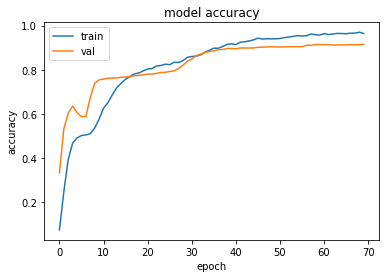

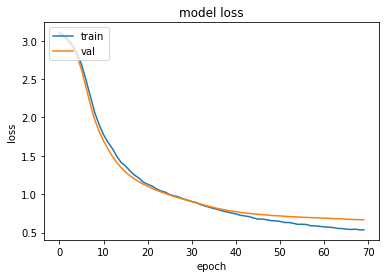

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Trực quan dữ liệu mất
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
results = model.evaluate(test_ds, test_lb)

print(results)

27/27 [==============================] - 0s 12ms/step - loss: 0.6722 - accuracy: 0.9280
[0.6721687912940979, 0.9279811382293701]


In [23]:
from sklearn.metrics import classification_report

predictions = model.predict(test_ds)
print(classification_report(test_lb, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       328
           1       0.85      0.69      0.76       126
           2       0.93      0.96      0.94       393

    accuracy                           0.93       847
   macro avg       0.91      0.88      0.89       847
weighted avg       0.93      0.93      0.93       847



## Mô hình KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in [1, 3, 5, 10, 20, 50]:
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(train_ds, train_lb)
    acc = knn_clf.score(train_ds, train_lb)
    print(f"n_neighbors: {n_neighbors} - acc: {acc}")

n_neighbors: 1 - acc: 0.9992119779353822
n_neighbors: 3 - acc: 0.9550827423167849
n_neighbors: 5 - acc: 0.9424743892829
n_neighbors: 10 - acc: 0.9231678486997635
n_neighbors: 20 - acc: 0.8912529550827423
n_neighbors: 50 - acc: 0.818360914105595


In [25]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(train_ds, train_lb)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [26]:
print("Acc trên tập train:", knn_clf.score(train_ds, train_lb))
print("Acc trên tập test:", knn_clf.score(test_ds, test_lb))
print(classification_report(test_lb, knn_clf.predict(test_ds)))

Acc trên tập train: 0.9444444444444444
Acc trên tập test: 0.9161747343565525
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       328
           1       0.78      0.75      0.76       126
           2       0.95      0.92      0.93       393

    accuracy                           0.92       847
   macro avg       0.89      0.88      0.88       847
weighted avg       0.92      0.92      0.92       847



In [63]:
s = my_tokenizer('SƠN TÙNG M-TP | CÓ CHẮC YÊU LÀ ĐÂY | OFFICIAL MUSIC VIDEO')
s = standardize_data(s)
s

'sơn tùng mtp có chắc yêu là đây official_music_video'

# Thử nghiệm dữ liệu mới

In [65]:
title = ['sơn tùng mtp có chắc yêu là đây official_music_video']

tags = ['son tung|sơn tùng|son tung mtp|sơn tùng mtp|có chắc yêu là đây|co chac yeu la day|sơn tùng có chắc yêu là đây|son tung co chac yeu la day|sơn tùng mtp có chắc yêu là đây|son tung mtp co chac yeu la day|có chắc yêu là đây sơn tùng|co chac yeu la day son tung|co chac yeu la day son tung mtp|mv son tung|mv sơn tùng|mv sơn tùng mtp|mv son tung mtp|sơn tùng m-tp|sơn tùng mới nhất|son tung mtp mới nhất|mtp|mv co chac yeu la day|mv có chắc yêu là đây']
tags.append(10)
tags.append(0)
tags.append(0)
tags.append((3125219/(3125219+96412)))

tags_df_test = pd.DataFrame([tags], columns = ['tags', 'categoryID', 'madeForKids','Label', 'rate'])

tags_df_test = pd.concat([tags_df_test, save_youtube_df])
tags_df_test[['categoryID', 'madeForKids', 'rate']] = scaler.fit_transform(tags_df_test[['categoryID', 'madeForKids', 'rate']])
tags_df_test = tags_df_test.iloc[[0]]


new = tags[0].split('|')

for i in range(0, len(new)):
        name = 'tag_{}'.format(i) 
        tags_df_test[name] = new[i]
for i in range(len(new), max_of_tags):
        name = 'tag_{}'.format(i) 
        tags_df_test[name] = 'notag'
tags_df_test.drop(columns=['tags'], inplace=True)
tags_df_test.fillna('notag', inplace=True)


list_df_test = create_matrix_pruned_tags(tags_df_test, ['categoryID', 'madeForKids', 'Label', 'rate'])
list_tmp = list_df
list_tmp.append(list_df_test[0])




tags_df_test = pd.DataFrame(list_tmp)
tags_df_test.fillna(0.0, inplace = True)
tags_df_test = tags_df_test.iloc[[-1]]
tags_df_test = tags_df_test.reset_index(drop=True)


preprocessed_news = model_rf_preprocess.transform(title)
title_df_test = pd.DataFrame(preprocessed_news.todense(), columns=module_count_vector.get_feature_names())

test = title_df_test.merge(tags_df_test, left_index=True, right_index=True, how='left')
if "Label" in test.columns:
    test = test.drop(['Label'], axis = 1)
test.fillna(0.0, inplace = True)
print(test)
a = model.predict_classes(test)
print(a)
if a == 0:
    print('Phù hợp')
elif a == 1:
    print('Bình thường')
else:
    print('Không phù hợp') 

   006   01  011  0175   02  021   03   04   05  05072018  ...  \
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...   

   hậu hoàng mới nhất  FAPtivi  cơm nguội  Ribi Sachi  Thai Vu  hai moi 2015  \
0                 0.0      0.0        0.0         0.0      0.0           0.0   

   ba tan hài hước  ribi  hau hoang 2020  Nhạc chế hậu hoàng  
0              0.0   0.0             0.0                 0.0  

[1 rows x 10139 columns]
[2]
Không phù hợp


In [58]:
test.to_csv(r'data/test_1.csv', index = False)

In [29]:
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model\assets
